# Example of the prediction of the semi-supervised pose model for art

## Loading of dependencies and definition of auxiliary functions 

In [5]:
!pip install huggingface_hub;
import numpy as np
import torch
from huggingface_hub import hf_hub_url, cached_download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 163 kB 4.8 MB/s 


In [6]:


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2, (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)


def box_xyxy_to_4points(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [x0, y0, x1, y1, x0, y1, x1, y0]
    return torch.stack(b, dim=-1)


def box_4points_to_xyxy(x):
    x0, y0, x1, y1, x2, y2, x3, y3 = x.unbind(-1)
    xs = torch.stack([x0, x1, x2, x3], dim=-1)
    ys = torch.stack([y0, y1, y2, y3], dim=-1)

    b = [
        torch.min(xs, dim=-1).values,
        torch.min(ys, dim=-1).values,
        torch.max(xs, dim=-1).values,
        torch.max(ys, dim=-1).values,
    ]
    return torch.stack(b, dim=-1)


def point_to_abs(points, size):

    original_shape = points.shape
    points = points.reshape(-1, original_shape[-1])
    points, meta = points[:, :2], points[:, 2:]
    points = points * torch.as_tensor([size[1], size[0]], device=points.device)

    transformed_points = torch.cat([points, meta], dim=-1)
    return transformed_points.reshape(original_shape)


def point_to_rel(points, size):

    original_shape = points.shape
    points = points.reshape(-1, original_shape[-1])
    points, meta = points[:, :2], points[:, 2:]
    points = points / torch.as_tensor([size[1], size[0]], device=points.device)

    transformed_points = torch.cat([points, meta], dim=-1)
    return transformed_points.reshape(original_shape)


def points_transformation(points, transformation):
    original_shape = points.shape

    # prepare points [N,3]
    points = points.reshape(-1, original_shape[-1])
    points, meta = points[:, :2], points[:, 2:]
    points = torch.cat([points, torch.as_tensor([[1.0]] * points.shape[0], device=points.device)], dim=1)
    points = points.unsqueeze(2)

    # prepare transformation [N,3,3]
    if len(transformation.shape) == 2:
        transformation = torch.unsqueeze(transformation, dim=0).expand(points.shape[0], 3, 3)

    transformed_points = transformation @ points
    transformed_points = torch.cat([torch.squeeze(transformed_points, 2)[:, :2], meta], dim=-1)
    return transformed_points.reshape(original_shape)


def boxes_to_abs(boxes, size):

    original_shape = boxes.shape
    boxes = boxes.reshape(-1, original_shape[-1])
    boxes, meta = boxes[:, :4], boxes[:, 4:]
    boxes = boxes * torch.as_tensor([size[1], size[0], size[1], size[0]], device=boxes.device)

    transformed_boxes = torch.cat([boxes, meta], dim=-1)
    return transformed_boxes.reshape(original_shape)


def boxes_to_rel(boxes, size):

    original_shape = boxes.shape
    boxes = boxes.reshape(-1, original_shape[-1])
    boxes, meta = boxes[:, :4], boxes[:, 4:]
    boxes = boxes / torch.as_tensor([size[1], size[0], size[1], size[0]], device=boxes.device)

    transformed_boxes = torch.cat([boxes, meta], dim=-1)
    return transformed_boxes.reshape(original_shape)


def boxes_transformation(boxes, transformation):
    original_shape = boxes.shape

    # prepare points [N,3]
    points = boxes.reshape(-1, original_shape[-1])
    # should be possible with a single reshape
    points_xyxy, meta = points[:, :4], points[:, 4:]
    # we need to compute all 4 points

    points = box_xyxy_to_4points(points_xyxy)
    points = points.reshape(-1, 2)
    transformed_points = points_transformation(points, transformation)
    transformed_points = transformed_points.reshape(-1, 8)

    transformed_points = box_4points_to_xyxy(transformed_points)

    transformed_points = torch.cat([transformed_points, meta], dim=-1)
    return transformed_points.reshape(original_shape)


def boxes_fit_size(boxes, size):
    h, w = size[0], size[1]

    original_shape = boxes.shape

    max_size = torch.as_tensor([w, h], dtype=torch.float32, device=size.device)
    boxes = torch.min(boxes.reshape(-1, 2, 2), max_size)
    boxes = boxes.clamp(min=0)

    return boxes.reshape(original_shape)


def boxes_scale(boxes, scale, size=None):

    box_cxcywh = box_xyxy_to_cxcywh(boxes)
    scaled_box_wh = box_cxcywh[2:] * scale
    scaled_box = box_cxcywh_to_xyxy(torch.cat([box_cxcywh[:2], scaled_box_wh], dim=0))
    if size is not None:
        scaled_box = boxes_fit_size(scaled_box, size)

    return scaled_box


def boxes_aspect_ratio(boxes, aspect_ratio, size=None):
    box_cxcywh = box_xyxy_to_cxcywh(boxes)
    w, h = box_cxcywh[2], box_cxcywh[3]
    n_w, n_h = w, h
    if w > aspect_ratio * h:
        n_h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        n_w = h * aspect_ratio
    scaled_box = box_cxcywh_to_xyxy(torch.stack([box_cxcywh[0], box_cxcywh[1], n_w, n_h], dim=0))
    if size is not None:
        scaled_box = boxes_fit_size(scaled_box, size)
    return scaled_box


## Person detection

In [7]:

def post_process_person_predictions(pred_logits, pred_boxes, targets, threshold=0.1):

    predictions = {"boxes": [], "labels": [], "size": targets["size"], "scores": []}

    batch_size = pred_logits.shape[0]

    label_softmax = torch.softmax(pred_logits, dim=-1)
    top_prediction = label_softmax > threshold
    boxes_pos = top_prediction[..., :-1].nonzero()

    for b in range(batch_size):
        boxes = []
        labels = []
        scores = []
        inv_transformation = torch.linalg.inv(targets["transformation"][b])
        weak_boxes_abs = boxes_to_abs(box_cxcywh_to_xyxy(pred_boxes[b]), size=targets["size"][b])
        boxes_origins_abs = boxes_transformation(weak_boxes_abs, inv_transformation)

        boxes_sample = boxes_pos[boxes_pos[:, 0] == b]

        for box in boxes_sample.unbind(0):
            box_index = box[1]
            box_cls = box[2]
            box_cxcywh = boxes_origins_abs[box_index]
            box_score = label_softmax[b, box_index, box_cls]
            labels.append(box_cls)
            boxes.append(box_cxcywh)
            scores.append(box_score)
        if len(boxes) > 0:
            predictions["boxes"].append(torch.stack(boxes, dim=0))
            predictions["labels"].append(torch.stack(labels, dim=0))
            predictions["scores"].append(torch.stack(scores, dim=0))
        else:
            predictions["boxes"].append(
                torch.zeros(
                    [0, 4],
                    device=label_softmax.device,
                )
            )
            predictions["labels"].append(torch.zeros([0], dtype=torch.int64, device=label_softmax.device))
            predictions["scores"].append(torch.zeros([0], device=label_softmax.device))
    return predictions


In [8]:
REPO_ID = "springsteinm/iart-semi-pose"
FILENAME = "popart_semi_bbox_v1_trace.pt"

person_model = torch.jit.load(cached_download(hf_hub_url(REPO_ID, FILENAME)))

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:591: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/334M [00:00<?, ?B/s]

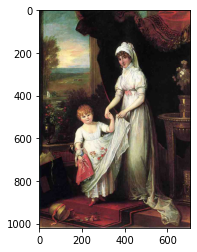

In [9]:
import imageio
import matplotlib.pyplot as plt
example_image = "https://github.com/TIBHannover/iart-semi-pose/raw/main/notebooks/benjamin-west_mrs-thomas-keyes-and-her-daughter.jpg"

image = imageio.imread(example_image)
plt.imshow(image)

In [10]:
prediction = person_model(torch.from_numpy(image))

# targets describes the change of the image before it was given into the model, here everything is left on default.
targets = {
    "size": [image.shape[0:2]],
    "origin_size": [image.shape[0:2]],
    "transformation": [torch.tensor([[1.0, 0.0, 0.0000], [0.0000, 1.0, 0.0000], [0.0000, 0.0, 1.0000]])],
}
final_person_prediciton = post_process_person_predictions(prediction[0], prediction[1], targets=targets)

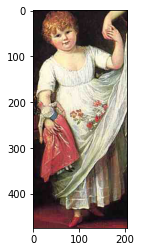

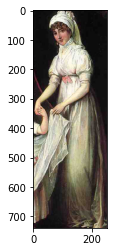

In [11]:
cropped_images = []
for box in final_person_prediciton["boxes"][0]:
  xyxy = box_cxcywh_to_xyxy(box).detach().numpy()
  box_image = image[max(0,int(box[1])):int(box[3]),max(0,int(box[0])):int(box[2]),:]
  fig, axs = plt.subplots(1, 1)
  axs.imshow(box_image)
  cropped_images.append(box_image)

## Keypoint detection

In [51]:
from scipy.optimize import linear_sum_assignment

def post_process_keypoint_predictions(pred_logits, pred_coords, targets, threshold=0.1):
  translated_coords = []
  for b in range(len(targets["transformation"])):
      # print(b)
      # print(out_coords.shape)
      inv_transformation = torch.linalg.inv(targets["transformation"][b])
      coords_abs = point_to_abs(pred_coords[b], targets["size"][b])
      coords_origin_abs = points_transformation(coords_abs, inv_transformation)
      translated_coords.append(coords_origin_abs)
      # print(coords_origin_abs)
  out_coords = torch.stack(translated_coords, dim=0)

  assert len(pred_logits) == len(targets["size"])
  assert torch.as_tensor(targets["size"]).shape[1] == 2

  num_joints = pred_logits.shape[-1] - 1

  prob = torch.nn.functional.softmax(pred_logits, -1)

  prob_cpu = torch.nn.functional.softmax(pred_logits[..., :-1], dim=-1).detach().cpu()

  _, labels = prob[..., :-1].max(-1)

  scores_list = []
  coords_list = []
  labels_list = []
  for b, C in enumerate(prob_cpu):

      _, query_ind = linear_sum_assignment(-C.transpose(0, 1))  # Cost Matrix: [17, N]
      score = prob_cpu[b, query_ind, list(np.arange(num_joints))].numpy()

      coord = out_coords[b, query_ind].detach().cpu().numpy()
      scores_list.append(torch.as_tensor(score))
      coords_list.append(torch.as_tensor(coord))
      labels_list.append(labels[b, query_ind])
  scores = torch.stack(scores_list)
  coords = torch.stack(coords_list)
  labels = torch.stack(labels_list)

  results = [
      {"scores": s, "labels": l, "keypoints": b, "selected": s > threshold}
      for s, l, b in zip(scores, labels, coords)
  ]

  return results

import cv2

def plot_prediction_images_cv2(
    image, output_path=None, boxes=None, keypoints=None, keypoints_labels=None, keypoints_scores=None, min_scores=0.9
):
    plot = image.copy()
    # fig, ax = plt.subplots(frameon=False)
    # ax.set_axis_off()
    # tab10
    color_lut = [
        [31, 119, 180],
        [255, 127, 14],
        [44, 160, 44],
        [214, 39, 40],
        [148, 103, 189],
        [140, 86, 75],
        [227, 119, 194],
        [127, 127, 127],
        [188, 189, 34],
        [23, 190, 207],
        [174, 199, 232],
        [255, 187, 120],
        [152, 223, 138],
        [255, 152, 150],
        [196, 156, 148],
        [197, 176, 213],
        [199, 199, 199],
        [219, 219, 141],
        [158, 218, 229],
    ]

    bones_lut = [
        [16, 14],
        [14, 12],
        [17, 15],
        [15, 13],
        [12, 13],
        [6, 12],
        [7, 13],
        [6, 7],
        [6, 8],
        [7, 9],
        [8, 10],
        [9, 11],
        [2, 3],
        [1, 2],
        [1, 3],
        [2, 4],
        [3, 5],
        [4, 6],
        [5, 7],
    ]
    # ax.imshow(image)
    if boxes is not None:
        for i, box in enumerate(boxes):
            box = np.asarray(box)
            box[box < 0] = 0
            box = np.rint(box).astype(np.uint)
            cv2.rectangle(plot, box[0:2], box[2:4], color=color_lut[i % len(color_lut)], thickness=2)
            # rect = Rectangle(
            #     [box[0], box[1]],
            #     box[2] - box[0],
            #     box[3] - box[1],
            #     linewidth=1,
            #     edgecolor="r",
            #     facecolor="none",
            # )
            # ax.add_patch(rect)

    if keypoints is not None:
        # print(keypoints)
        # print(keypoints_labels)
        # print(keypoints_scores)
        # exit()
        for j, (pose, labels) in enumerate(zip(keypoints, keypoints_labels)):
            point_lut = {}
            pose = np.rint(np.asarray(pose)).astype(np.uint)
            for i, (keypoint, label) in enumerate(zip(pose, labels)):
                if keypoints_scores is not None:
                    if keypoints_scores[j][i] < min_scores:
                        continue

                point_lut[label.numpy().item()] = keypoint
                # print(f"{keypoint} {label}")
                cv2.circle(plot, keypoint, radius=2, color=color_lut[label], thickness=2)

            for i, bone in enumerate(bones_lut):
                if bone[0] - 1 not in point_lut or bone[1] - 1 not in point_lut:
                    continue
                cv2.line(plot, point_lut[bone[0] - 1], point_lut[bone[1] - 1], color=color_lut[i], thickness=2)

    if output_path:
      imageio.imwrite(output_path, plot)
    return plot

In [47]:
REPO_ID = "springsteinm/iart-semi-pose"
FILENAME = "popart_semi_kpoint_v1_trace.pt"

keypoint_model = torch.jit.load(cached_download(hf_hub_url(REPO_ID, FILENAME)))

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:591: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


(475, 206, 3)
{'scores': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000,
        0.9999, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]), 'labels': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'keypoints': tensor([[ 96.8333,  51.8695],
        [105.7649,  36.9937],
        [ 78.0937,  45.8997],
        [130.0443,  34.1008],
        [ 61.2379,  56.5879],
        [169.9564,  76.9336],
        [ 50.3516,  99.1710],
        [252.7795,  93.4564],
        [ 29.2176, 150.7764],
        [261.8681,  57.1362],
        [ 38.0994, 190.1215],
        [199.4117, 201.8312],
        [120.0252, 216.0758],
        [227.1771, 273.1844],
        [ 98.5643, 283.4541],
        [218.7736, 342.1790],
        [131.2977, 354.8406]]), 'selected': tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True])}
{'scores': [tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 

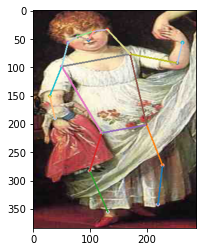

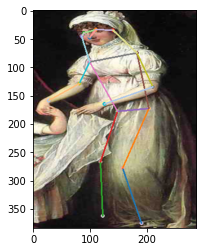

In [60]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
from typing import List, Tuple, Any, Optional

import PIL
import random
import math


for person_image in cropped_images:
  print(person_image.shape)

  mean = [int(255 * x) for x in [0.485, 0.456, 0.406]]
  person_image = np.array(F.resize(F.to_pil_image(person_image), [384,288]))
  
  prediction = keypoint_model(torch.from_numpy(person_image))

  targets = {
      "size": [person_image.shape[0:2]],
      "origin_size": [person_image.shape[0:2]],
      "transformation": [torch.tensor([[1.0, 0.0, 0.0000], [0.0000, 1.0, 0.0000], [0.0000, 0.0, 1.0000]])],
  }
  # targets describes the change of the image before it was given into the model, here everything is left on default.

  final_keypoint_prediciton = post_process_keypoint_predictions(prediction[0], prediction[1], targets=targets)[0]
  print(final_keypoint_prediciton)

  for k, v in final_keypoint_prediciton.items():
    final_keypoint_prediciton[k] = [v.detach()]
  print(final_keypoint_prediciton)
  plot = plot_prediction_images_cv2(person_image, keypoints=final_keypoint_prediciton["keypoints"], keypoints_labels=final_keypoint_prediciton["labels"], keypoints_scores=final_keypoint_prediciton["scores"])
  fig, axs = plt.subplots(1, 1)
  axs.imshow(plot)